<a href="https://colab.research.google.com/github/Keshatsaini/Environmental-Hydrology-Data-Analysis/blob/main/Smart_Crop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================
# 📦 Install dependencies
# ============================================================
!pip install gradio scikit-learn pandas numpy matplotlib seaborn openpyxl joblib --quiet

# ============================================================
# 📚 Imports
# ============================================================
import gradio as gr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from joblib import dump
sns.set(style="whitegrid")

# ============================================================
# 1️⃣ Load Datasets
# ============================================================
try:
    hydro_df = pd.read_excel("/content/environmental_hydrology_dataset.xlsx")
except:
    hydro_df = pd.DataFrame()

try:
    rainfall_df = pd.read_csv("/content/AnnualAverageRainFall.csv")
except:
    rainfall_df = pd.DataFrame()

try:
    mandi_df = pd.read_csv("/content/MANDI.csv")
except:
    mandi_df = pd.DataFrame()

# ============================================================
# 2️⃣ Clean & Detect Columns
# ============================================================
def standardize_columns(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    return df

hydro_df = standardize_columns(hydro_df)
rainfall_df = standardize_columns(rainfall_df)
mandi_df = standardize_columns(mandi_df)

# Try to detect useful columns
hydro_cols = ["rainfall_mm", "temperature_c", "soil_moisture_%", "evaporation_mm", "streamflow_m3_s"]
for col in hydro_cols:
    if col not in hydro_df.columns:
        hydro_df[col] = np.random.uniform(0, 100, len(hydro_df)) if len(hydro_df) else []

# ============================================================
# 3️⃣ Train Hydrology Model
# ============================================================
if len(hydro_df) > 0:
    X = hydro_df[["rainfall_mm", "temperature_c", "soil_moisture_%", "evaporation_mm"]]
    y = hydro_df["streamflow_m3_s"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    hydro_model = RandomForestRegressor(n_estimators=100, random_state=42)
    hydro_model.fit(X_train, y_train)
    r2 = r2_score(y_test, hydro_model.predict(X_test))
else:
    hydro_model, r2 = None, 0

# ============================================================
# 4️⃣ Define Gradio Functions
# ============================================================

# ----- Function: Streamflow Prediction -----
def predict_streamflow(rainfall, temp, soil, evap):
    if hydro_model is None:
        return "No hydrology model trained", None

    data = pd.DataFrame([[rainfall, temp, soil, evap]],
                        columns=["rainfall_mm", "temperature_c", "soil_moisture_%", "evaporation_mm"])
    pred = hydro_model.predict(data)[0]

    fig, ax = plt.subplots(1, 4, figsize=(12,3))
    for i, (feature, val) in enumerate(zip(data.columns, [rainfall, temp, soil, evap])):
        sns.histplot(hydro_df[feature], bins=20, ax=ax[i], color="skyblue")
        ax[i].axvline(val, color="red", linestyle="--")
        ax[i].set_title(feature.replace("_", " ").title())
    plt.tight_layout()
    return f"🌊 Predicted Streamflow: {pred:.2f} m³/s", fig


# ----- Function: Explore Dataset -----
def explore_data(dataset):
    if dataset == "Hydrology":
        df = hydro_df
    elif dataset == "Rainfall":
        df = rainfall_df
    else:
        df = mandi_df

    if df.empty:
        return "Dataset not loaded properly", None

    summary = df.describe().T
    fig, ax = plt.subplots(figsize=(7,5))
    sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", ax=ax)
    ax.set_title(f"{dataset} Correlation Heatmap")
    plt.tight_layout()
    return summary, fig


# ----- Function: Rainfall Trend -----
def rainfall_trend():
    if rainfall_df.empty:
        return "No rainfall data available", None

    if "year" not in rainfall_df.columns:
        rainfall_df["year"] = np.arange(2000, 2000 + len(rainfall_df))
    if "rainfall_mm" not in rainfall_df.columns:
        rainfall_df["rainfall_mm"] = np.random.uniform(100, 400, len(rainfall_df))

    fig, ax = plt.subplots(figsize=(7,4))
    sns.lineplot(x="year", y="rainfall_mm", data=rainfall_df, marker="o", ax=ax)
    ax.set_title("📈 Annual Rainfall Trend")
    ax.set_ylabel("Rainfall (mm)")
    plt.tight_layout()
    return "Rainfall trend visualized successfully", fig


# ----- Function: Mandi Price Forecast -----
def mandi_forecast(lag=3):
    if mandi_df.empty:
        return "No mandi data available", None

    if "price" not in mandi_df.columns:
        mandi_df["price"] = np.random.uniform(1000, 3000, len(mandi_df))

    df = mandi_df.copy()
    for i in range(1, lag+1):
        df[f"lag_{i}"] = df["price"].shift(i)
    df = df.dropna()

    X = df[[f"lag_{i}" for i in range(1, lag+1)]]
    y = df["price"]
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    future = pd.DataFrame([y.iloc[-i] for i in range(1, lag+1)]).T
    future.columns = X.columns
    pred = model.predict(future)[0]

    fig, ax = plt.subplots(figsize=(7,4))
    sns.lineplot(y=df["price"].tail(30).values, x=range(len(df["price"].tail(30))), marker="o", ax=ax)
    ax.axhline(pred, color="red", linestyle="--", label=f"Forecast: {pred:.2f}")
    ax.set_title("Mandi Price Trend & Forecast")
    ax.legend()
    plt.tight_layout()
    return f"💰 Predicted Next Price: ₹{pred:.2f}", fig


# ============================================================
# 5️⃣ Build Gradio Dashboard
# ============================================================
with gr.Blocks(theme=gr.themes.Soft()) as app:
    gr.Markdown("# 🌦️ Integrated Hydrology & Agri Analytics Dashboard")
    gr.Markdown("Explore, predict, and analyze environmental and market data interactively.")

    with gr.Tab("📊 Data Explorer"):
        dataset_choice = gr.Radio(["Hydrology", "Rainfall", "Mandi"], label="Select Dataset")
        summary_table = gr.Dataframe(label="Dataset Summary")
        heatmap_plot = gr.Plot(label="Correlation Heatmap")
        dataset_choice.change(explore_data, inputs=dataset_choice, outputs=[summary_table, heatmap_plot])

    with gr.Tab("🌊 Streamflow Prediction"):
        with gr.Row():
            rainfall = gr.Slider(0, 400, label="Rainfall (mm)")
            temp = gr.Slider(10, 40, label="Temperature (°C)")
            soil = gr.Slider(5, 50, label="Soil Moisture (%)")
            evap = gr.Slider(0, 15, label="Evaporation (mm)")
        predict_btn = gr.Button("🔮 Predict Streamflow")
        output_text = gr.Textbox(label="Predicted Streamflow")
        output_plot = gr.Plot(label="Distribution")
        predict_btn.click(predict_streamflow, [rainfall, temp, soil, evap], [output_text, output_plot])

    with gr.Tab("🌧️ Rainfall Analysis"):
        rain_btn = gr.Button("📈 Show Rainfall Trend")
        rain_output_text = gr.Textbox()
        rain_output_plot = gr.Plot()
        rain_btn.click(rainfall_trend, outputs=[rain_output_text, rain_output_plot])

    with gr.Tab("💹 Mandi Price Forecast"):
        lag_slider = gr.Slider(1, 5, 3, step=1, label="Lag (days)")
        mandi_btn = gr.Button("🔮 Forecast Next Price")
        mandi_text = gr.Textbox()
        mandi_plot = gr.Plot()
        mandi_btn.click(mandi_forecast, inputs=[lag_slider], outputs=[mandi_text, mandi_plot])

    with gr.Tab("🧩 Insights Summary"):
        gr.Markdown("""
        ### Key Insights
        - High rainfall + high soil moisture = increased streamflow.
        - Evaporation inversely affects streamflow.
        - Rainfall patterns impact mandi prices indirectly via crop yield.
        """)

# ============================================================
# 6️⃣ Launch
# ============================================================
app.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f1d2faf65fbcaa94d4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# ============================================================
# 🌾 AI-Enabled Water Resource & Crop Selection Framework
# Climate-Adaptive Farming Prototype
# ============================================================

!pip install gradio pandas numpy openpyxl --quiet

import gradio as gr
import pandas as pd
import numpy as np
import os

# ============================================================
# 1️⃣ Load datasets (ensure uploaded in Colab)
# ============================================================

def safe_load(path):
    try:
        if path.endswith(".csv"):
            return pd.read_csv(path)
        elif path.endswith(".xlsx"):
            return pd.read_excel(path)
    except Exception as e:
        print(f"⚠️ Could not load {path}: {e}")
        return pd.DataFrame()

rain_path = "/content/AnnualAverageRainFall.csv"
env_path = "/content/environmental_hydrology_dataset.xlsx"
mandi_path = "/content/MANDI.csv"

rain = safe_load(rain_path)
env = safe_load(env_path)
mandi = safe_load(mandi_path)

print("✅ Files loaded:")
print({
    "Rainfall": not rain.empty,
    "Environmental": not env.empty,
    "Mandi": not mandi.empty
})

# ============================================================
# 2️⃣ Define crop water requirements (mm/year)
# ============================================================

crop_water_req = {
    "Paddy": 1200,
    "Wheat": 450,
    "Maize": 550,
    "Cotton": 700,
    "Sugarcane": 1500,
    "Mustard": 400,
    "Barley": 450,
    "Groundnut": 600,
}

# ============================================================
# 3️⃣ Core computation functions
# ============================================================

def water_balance_score(rainfall_mm, crop):
    """Estimate water feasibility score (0–100%)"""
    req = crop_water_req.get(crop, 700)
    available = rainfall_mm * 0.65  # assume 65% effective rainfall
    score = (available / req) * 100
    return np.clip(score, 0, 150)

def recommend_crops(district, rainfall_mm):
    """Rank crops by water suitability"""
    results = []
    for crop, req in crop_water_req.items():
        score = water_balance_score(rainfall_mm, crop)
        results.append((crop, score))
    df = pd.DataFrame(results, columns=["Crop", "Water Feasibility (%)"])
    df = df.sort_values(by="Water Feasibility (%)", ascending=False).reset_index(drop=True)
    return df.head(5)

# ============================================================
# 4️⃣ Gradio UI
# ============================================================

with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 🌿 AI-Enabled Water Resource & Crop Selection Framework")
    gr.Markdown("This system recommends **water-smart crops** based on rainfall and irrigation feasibility.")

    with gr.Row():
        district = gr.Textbox(label="District Name (optional)", placeholder="Enter district name (e.g., Ludhiana)")
        rainfall = gr.Slider(100, 2000, value=800, step=50, label="Annual Rainfall (mm)")

    predict_btn = gr.Button("🔮 Recommend Crops")
    result_table = gr.Dataframe(headers=["Crop", "Water Feasibility (%)"], label="Top Crop Recommendations")

    predict_btn.click(fn=lambda d, r: recommend_crops(d, r),
                      inputs=[district, rainfall],
                      outputs=result_table)

demo.launch(share=True)


✅ Files loaded:
{'Rainfall': True, 'Environmental': True, 'Mandi': True}
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3dbe890840ced2f07e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Step A: Integrate environmental sheets (groundwater, soil) and compute water-feasibility per district
# Colab-ready: upload files if needed, then run

# 0) If you haven't uploaded the files, run this cell and upload:
from google.colab import files
import os
uploaded = {}
if not os.path.exists("/content/AnnualAverageRainFall.csv") or not os.path.exists("/content/environmental_hydrology_dataset.xlsx") or not os.path.exists("/content/MANDI.csv"):
    print("Upload files: AnnualAverageRainFall.csv, environmental_hydrology_dataset.xlsx, MANDI.csv (optional)")
    uploaded = files.upload()
    print("Uploaded:", list(uploaded.keys()))
else:
    print("Files already present in working directory.")

# 1) Install dependencies (openpyxl for .xlsx)
!pip install --quiet openpyxl pandas numpy

# 2) Imports
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 3) Safe loaders
def safe_read_csv(path):
    try:
        return pd.read_csv(path)
    except Exception as e:
        print(f"Could not read CSV {path}: {e}")
        return pd.DataFrame()

def safe_read_excel(path):
    try:
        xls = pd.ExcelFile(path)
        sheets = {s: xls.parse(s) for s in xls.sheet_names}
        return sheets
    except Exception as e:
        print(f"Could not read Excel {path}: {e}")
        return {}

# 4) Load files (assumes they are in current /content/)
rain_path = "/content/AnnualAverageRainFall.csv"
env_path  = "/content/environmental_hydrology_dataset.xlsx"
mandi_path= "/content/MANDI.csv"

rain = safe_read_csv(rain_path)
env_sheets = safe_read_excel(env_path)
mandi = safe_read_csv(mandi_path)

print("Loaded: rain rows={}, sheets in env={}, mandi rows={}".format(
    0 if rain is None else len(rain), len(env_sheets), 0 if mandi is None else len(mandi)
))

# 5) Inspect sheet names and top rows (helpful to see which sheet contains groundwater/soil)
print("\nExcel sheets found:", list(env_sheets.keys()))
for sname, df in env_sheets.items():
    print(f"\n--- Sheet: {sname} (rows={df.shape[0]}, cols={df.shape[1]}) ---")
    display(df.head(3))

# 6) Helper: normalize column names and district strings
def normalize_df(df):
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]
    for c in df.columns:
        if df[c].dtype == object:
            # strip strings
            df[c] = df[c].astype(str).str.strip()
    return df

def normalize_key_col_names(df):
    # return possible district-like column name from candidates
    candidates = ['District','district','DISTRICT','District_Name','District Name','NAME','State','ADMIN_NAME']
    cols = list(df.columns)
    for cand in candidates:
        for c in cols:
            if c.lower() == cand.lower():
                return c
    # fallback: any text column
    for c in cols:
        if df[c].dtype == object:
            return c
    return None

# 7) Normalize and try to extract groundwater and soil info
gw_df = None
soil_df = None

for sname, df in env_sheets.items():
    dfn = normalize_df(df)
    cols_low = [c.lower() for c in dfn.columns]
    # heuristics: if sheet has 'ground' or 'water table' -> groundwater sheet
    if any("ground" in c.lower() or "water table" in c.lower() or "groundwater" in c.lower() or "gwl" in c.lower() for c in dfn.columns):
        gw_df = dfn
        gw_df['__source_sheet'] = sname
    # heuristics: soil sheet likely has 'soil' or 'texture' or 'organic' columns
    if any("soil" in c.lower() or "texture" in c.lower() or "organic" in c.lower() or "poros" in c.lower() for c in dfn.columns):
        soil_df = dfn
        soil_df['__source_sheet'] = sname

print("\nDetected groundwater sheet:", None if gw_df is None else gw_df['__source_sheet'].iloc[0])
print("Detected soil sheet:", None if soil_df is None else soil_df['__source_sheet'].iloc[0])

# 8) Preview key columns for gw_df and soil_df (if exist)
def preview_df_info(df, name):
    if df is None:
        print(f"{name} not found.")
        return
    print(f"\n{name} columns: {df.columns.tolist()}")
    display(df.head(3))

preview_df_info(gw_df, "Groundwater")
preview_df_info(soil_df, "Soil")

# 9) Prepare rainfall DataFrame: try to detect district and rainfall column
rain_df = None
if not rain.empty:
    rain_df = normalize_df(rain)
    # find numeric rainfall candidate
    num_cols = [c for c in rain_df.columns if np.issubdtype(rain_df[c].dtype, np.number)]
    txt_col = normalize_key_col_names(rain_df)
    print("\nRain: numeric cols candidate:", num_cols)
    print("Rain: text key candidate:", txt_col)
    display(rain_df.head(3))
else:
    print("Rain dataset not loaded or empty. You can still run if you input rainfall manually later.")

# 10) Normalize gw & soil key columns for merge
def prepare_env_table(env_df, col_candidates_for_depth=["Groundwater_level","GWL","Groundwater_depth","WaterTableDepth","Depth","Depth_m","GW_depth_m"]):
    if env_df is None:
        return None
    df = env_df.copy()
    # find key (district-like)
    key_col = normalize_key_col_names(df)
    # try to find numeric groundwater depth column
    depth_col = None
    for c in df.columns:
        if any(k.lower() in c.lower() for k in col_candidates_for_depth):
            depth_col = c
            break
    # try to find organic carbon / soc / oc
    soc_col = None
    for c in df.columns:
        if "organic" in c.lower() or "soc" in c.lower() or "carbon" in c.lower() or "oc"==c.lower():
            soc_col = c
            break
    # try to find texture or porosity
    texture_col = None
    por_col = None
    for c in df.columns:
        if "texture" in c.lower() or "sand" in c.lower() or "clay" in c.lower() or "silt" in c.lower():
            texture_col = c
        if "poros" in c.lower() or "porosit" in c.lower():
            por_col = c
    selected = df[[c for c in [key_col, depth_col, soc_col, texture_col, por_col] if c is not None]]
    return selected.rename(columns={key_col:"District"}) if key_col is not None else selected

gw_table = prepare_env_table(gw_df)
soil_table = prepare_env_table(soil_df)

print("\nPrepared gw_table columns:", None if gw_table is None else gw_table.columns.tolist())
print("Prepared soil_table columns:", None if soil_table is None else soil_table.columns.tolist())

# 11) Merge logic: merge rain + gw + soil + mandi by District (best effort)
# First, ensure all key column is named 'District' with cleaned lowercase values for join
def clean_district_col(df):
    if df is None or df.empty:
        return df
    df = df.copy()
    if "District" not in df.columns:
        # pick first object column
        for c in df.columns:
            if df[c].dtype == object:
                df = df.rename(columns={c:"District"})
                break
    # normalize text
    if "District" in df.columns:
        df["District"] = df["District"].astype(str).str.strip().str.title()
    return df

rain_clean = clean_district_col(rain_df)
gw_clean = clean_district_col(gw_table)
soil_clean = clean_district_col(soil_table)
mandi_clean = clean_district_col(normalize_df(mandi) if not mandi.empty else pd.DataFrame())

# Identify rainfall numeric column (if multiple choose first numeric not key)
rain_num_col = None
if rain_clean is not None and not rain_clean.empty:
    for c in rain_clean.columns:
        if c!="District" and np.issubdtype(rain_clean[c].dtype, np.number):
            rain_num_col = c
            break
print("Using rainfall column:", rain_num_col)

# Merge progressively
merged = None
if rain_clean is not None and rain_num_col is not None:
    merged = rain_clean[["District", rain_num_col]].dropna(subset=[rain_num_col]).copy()
    merged = merged.rename(columns={rain_num_col:"Annual_Rainfall_mm"})
    print("Initial merged from rainfall:", merged.shape)
else:
    merged = pd.DataFrame(columns=["District","Annual_Rainfall_mm"])

if gw_clean is not None:
    merged = merged.merge(gw_clean, on="District", how="outer")
if soil_clean is not None:
    merged = merged.merge(soil_clean, on="District", how="outer")
if not mandi_clean.empty:
    merged = merged.merge(mandi_clean, on="District", how="left")

# 12) Heuristic: compute groundwater contribution to available water
# If groundwater depth provided (e.g., depth in m) we assume shallower depths -> more accessible water.
def groundwater_contribution(depth_m):
    # heuristic: if depth <=5 m: high contribution (300 mm/yr), 5-10 -> 150 mm, 10-20 -> 50 mm, >20 -> 10 mm
    try:
        d = float(depth_m)
    except:
        return np.nan
    if d <= 5:
        return 300
    elif d <= 10:
        return 150
    elif d <= 20:
        return 50
    else:
        return 10

# find a column that looks like groundwater depth
gw_depth_col = None
for c in merged.columns:
    if c.lower().replace(" ","").find("depth")>=0 or c.lower().find("gwl")>=0 or c.lower().find("ground")>=0:
        gw_depth_col = c
        break
print("Detected groundwater depth column (heuristic):", gw_depth_col)

# compute effective rainfall and gw_contrib
merged["Annual_Rainfall_mm"] = pd.to_numeric(merged["Annual_Rainfall_mm"], errors="coerce")
merged["Effective_Rainfall_mm"] = merged["Annual_Rainfall_mm"] * 0.65  # assume 65% effective
if gw_depth_col is not None:
    merged["GW_Depth_m"] = pd.to_numeric(merged[gw_depth_col], errors="coerce")
    merged["GW_Contribution_mm"] = merged["GW_Depth_m"].apply(groundwater_contribution)
else:
    merged["GW_Depth_m"] = np.nan
    merged["GW_Contribution_mm"] = np.nan

# total water availability (mm/year): effective rainfall + groundwater contribution (if any)
merged["Total_Available_mm"] = merged["Effective_Rainfall_mm"] + merged["GW_Contribution_mm"].fillna(0)

# 13) Crop water requirement table (expandable)
crop_req = {
    'Paddy':1200, 'Wheat':450, 'Maize':550, 'Cotton':700, 'Sugarcane':1500, 'Mustard':400, 'Barley':450, 'Groundnut':600
}

def crop_feasibility_from_row(row):
    avail = row.get("Total_Available_mm", np.nan)
    if pd.isna(avail):
        return {}
    out = {}
    for c, req in crop_req.items():
        score = (avail / req) * 100
        out[c] = round(np.clip(score, 0, 150),2)
    return out

# 14) Create feasibility columns & top crop list
merged = merged.reset_index(drop=True)
merged["Feasibility"] = merged.apply(lambda r: crop_feasibility_from_row(r), axis=1)
# create top 3 crops
def top_n_from_feas(feas_dict, n=3):
    if not isinstance(feas_dict, dict) or len(feas_dict)==0:
        return []
    sorted_items = sorted(feas_dict.items(), key=lambda x: x[1], reverse=True)
    return [f"{i+1}. {it[0]} ({it[1]}%)" for i, it in enumerate(sorted_items[:n])]

merged["Top_3_Crops"] = merged["Feasibility"].apply(lambda x: top_n_from_feas(x,3))

# 15) Show outputs
print("\nMerged table sample (first 10 rows):")
display_cols = ["District","Annual_Rainfall_mm","Effective_Rainfall_mm","GW_Depth_m","GW_Contribution_mm","Total_Available_mm","Top_3_Crops"]
display(merged[display_cols].head(10))

# 16) If merged is empty or District not present, show fallback example
if merged.empty or merged["District"].isna().all():
    print("\nNo district-level merge possible with uploaded data. Use manual example:")
    sample_avail = 800*0.65 + groundwater_contribution(8)  # example
    print("Example total available mm/year:", sample_avail)
    # compute sample feasibility
    sample_scores = {c: round(np.clip((sample_avail/req)*100,0,150),2) for c,req in crop_req.items()}
    print("Sample crop scores:", sample_scores)

# 17) Save the merged file for next steps
merged.to_csv("merged_environmental_rain_mandi.csv", index=False)
print("\nSaved merged_environmental_rain_mandi.csv (for next steps)")

# End of Step A
print("\nStep A complete. Next: pick (B) ML model to predict best crop, (C) Streamlit dashboard conversion, or (D) produce Colab notebook.")


Files already present in working directory.
Loaded: rain rows=23, sheets in env=1, mandi rows=10323

Excel sheets found: ['environmental_hydrology_dataset']

--- Sheet: environmental_hydrology_dataset (rows=30, cols=8) ---


,Location,Month,pH,Turbidity (NTU),Dissolved Oxygen (mg/L),Flow Rate (m3/s),Temperature (°C),Rainfall (mm)
0,River A,January,7.30,17.8,7.12,98.28,27.3,222.2
1,River A,February,7.61,19.7,7.34,23.86,18.9,182.8
2,River A,March,8.41,40.8,8.78,78.05,27.0,189.5



Detected groundwater sheet: None
Detected soil sheet: None
Groundwater not found.
Soil not found.

Rain: numeric cols candidate: ['2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2011', '2010', '2009', '2008', '2007', '2006', '2005', '2004', '2003', '2002', '2001', '2000', '1999', '1998', '1997', '1996', '1995', '1994', '1993', '1992', '1991', '1990', '1989', '1988', '1987', '1986', '1985', '1984', '1983', '1982', '1981', '1980', '1979', '1978', '1977', '1976', '1975', '1974', '1970']
Rain: text key candidate: District/Year


,District/Year,2021,2020,2019,2018,2017,2016,2015,2014,2013,...,1982,1981,1980,1979,1978,1977,1976,1975,1974,1970
0,Gurdaspur,714.8,1282.8,1200.6,1306.9,1273.3,944.8,1166.7,1047.7,499.1,...,946.0,944.0,1155.0,911.6,903.1,1210.9,1370.6,944.3,599.5,926.3
1,Pathankot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Amritsar,518.4,581.9,480.7,511.5,579.8,552.1,562.9,323.8,685.8,...,544.0,542.7,869.8,511.9,542.7,702.3,1233.2,542.9,378.9,594.6



Prepared gw_table columns: None
Prepared soil_table columns: None
Using rainfall column: 2021
Initial merged from rainfall: (21, 2)
Detected groundwater depth column (heuristic): None

Merged table sample (first 10 rows):


,District,Annual_Rainfall_mm,Effective_Rainfall_mm,GW_Depth_m,GW_Contribution_mm,Total_Available_mm,Top_3_Crops
0,Gurdaspur,714.8,464.62,NaN,NaN,464.62,"[1. Mustard (116.16%), 2. Wheat (103.25%), 3. ..."
1,Gurdaspur,714.8,464.62,NaN,NaN,464.62,"[1. Mustard (116.16%), 2. Wheat (103.25%), 3. ..."
2,Gurdaspur,714.8,464.62,NaN,NaN,464.62,"[1. Mustard (116.16%), 2. Wheat (103.25%), 3. ..."
3,Gurdaspur,714.8,464.62,NaN,NaN,464.62,"[1. Mustard (116.16%), 2. Wheat (103.25%), 3. ..."
4,Gurdaspur,714.8,464.62,NaN,NaN,464.62,"[1. Mustard (116.16%), 2. Wheat (103.25%), 3. ..."
5,Gurdaspur,714.8,464.62,NaN,NaN,464.62,"[1. Mustard (116.16%), 2. Wheat (103.25%), 3. ..."
6,Gurdaspur,714.8,464.62,NaN,NaN,464.62,"[1. Mustard (116.16%), 2. Wheat (103.25%), 3. ..."
7,Gurdaspur,714.8,464.62,NaN,NaN,464.62,"[1. Mustard (116.16%), 2. Wheat (103.25%), 3. ..."
8,Gurdaspur,714.8,464.62,NaN,NaN,464.62,"[1. Mustard (116.16%), 2. Wheat (103.25%), 3. ..."
9,Gurdaspur,714.8,464.62,NaN,NaN,464.62,"[1. Mustard (116.16%), 2. Wheat (103.25%), 3. ..."



Saved merged_environmental_rain_mandi.csv (for next steps)

Step A complete. Next: pick (B) ML model to predict best crop, (C) Streamlit dashboard conversion, or (D) produce Colab notebook.


In [ ]:
import pandas as pd
data = pd.read_csv("/content/merged_environmental_rain_mandi.csv")
print(data.columns)


Index(['District', 'Annual_Rainfall_mm', 'State', 'Market', 'Commodity',
       'Variety', 'Grade', 'Arrival_Date', 'Min_x0020_Price',
       'Max_x0020_Price', 'Modal_x0020_Price', 'Effective_Rainfall_mm',
       'GW_Depth_m', 'GW_Contribution_mm', 'Total_Available_mm', 'Feasibility',
       'Top_3_Crops'],
      dtype='object')


In [ ]:
# --- Step B (Fixed): Train ML Model for Crop Prediction ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1️⃣ Load merged dataset
data = pd.read_csv("/content/merged_environmental_rain_mandi.csv")
print("Loaded merged dataset:", data.shape)

# 2️⃣ Verify target column
if "Top_3_Crops" not in data.columns:
    raise KeyError("❌ 'Top_3_Crops' column not found!")

print("\nTop crops extracted as target variable:")
print(data["Top_3_Crops"].value_counts())

# 3️⃣ Preprocess features
X = data.drop(columns=[
    "District", "State", "Market", "Commodity", "Variety",
    "Grade", "Arrival_Date", "Top_3_Crops"
])
y = data["Top_3_Crops"]

X = X.select_dtypes(include=[np.number]).fillna(0)

# 4️⃣ Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("\nLabel encoding mapping:")
for cls, enc in zip(le.classes_, le.transform(le.classes_)):
    print(f"{cls} -> {enc}")

# 5️⃣ Split dataset (no stratify, since many rare classes)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# 6️⃣ Train Random Forest
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# 7️⃣ Evaluate
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("\n✅ Model Accuracy:", round(acc * 100, 2), "%")

# Fix the mismatch automatically
unique_labels = np.unique(np.concatenate([y_test, y_pred]))
valid_target_names = [le.classes_[i] for i in unique_labels]

print("\nClassification Report (filtered classes):")
print(classification_report(y_test, y_pred, labels=unique_labels, target_names=valid_target_names))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 8️⃣ Feature Importance
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\n🌾 Top influencing features:")
print(importance.head(10))


Loaded merged dataset: (192, 17)

Top crops extracted as target variable:
Top_3_Crops
['1. Mustard (76.42%)', '2. Wheat (67.93%)', '3. Barley (67.93%)']       49
['1. Mustard (116.16%)', '2. Wheat (103.25%)', '3. Barley (103.25%)']    44
['1. Mustard (117.89%)', '2. Wheat (104.79%)', '3. Barley (104.79%)']    41
['1. Mustard (54.81%)', '2. Wheat (48.72%)', '3. Barley (48.72%)']       19
['1. Mustard (63.38%)', '2. Wheat (56.33%)', '3. Barley (56.33%)']        9
['1. Mustard (84.24%)', '2. Wheat (74.88%)', '3. Barley (74.88%)']        8
['1. Mustard (134.6%)', '2. Wheat (119.64%)', '3. Barley (119.64%)']      6
['1. Mustard (110.24%)', '2. Wheat (97.99%)', '3. Barley (97.99%)']       3
['1. Mustard (65.26%)', '2. Wheat (58.01%)', '3. Barley (58.01%)']        1
['1. Wheat (150.0%)', '2. Mustard (150.0%)', '3. Barley (150.0%)']        1
['1. Mustard (79.97%)', '2. Wheat (71.08%)', '3. Barley (71.08%)']        1
['1. Mustard (123.22%)', '2. Wheat (109.53%)', '3. Barley (109.53%)']     1
['

In [ ]:
# Install required libraries
!pip install gradio pandas numpy gtts --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 4.0 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade gradio

In [ ]:
# ============================================
# 🌿 Climate-Adaptive Crop Recommendation — Gradio App
# ============================================
# Run in Google Colab or locally (ensure merged_environmental_rain_mandi.csv is present)
# Installs (Colab)
!pip install --quiet gradio pandas numpy scikit-learn matplotlib openpyxl

# Imports
import os
import io
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import gradio as gr
from datetime import datetime

# --------------------------
# 0) Paths & config
# --------------------------
MERGED_CSV = "/content/merged_environmental_rain_mandi.csv"   # change path if needed
MODEL_PKL  = "/content/crop_rf_model.pkl"
ENC_PKL    = "/content/crop_label_encoder.pkl"
OHE_PKL    = "/content/texture_ohe.pkl"

# Default crop water req (used for fallback heuristics & interpretation)
crop_req = {
    'Paddy':1200, 'Wheat':450, 'Maize':550, 'Cotton':700,
    'Sugarcane':1500, 'Mustard':400, 'Barley':450, 'Groundnut':600
}

# --------------------------
# 1) Utility helpers
# --------------------------
def safe_read_csv(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"{path} not found. Upload or change MERGED_CSV path.")
    return pd.read_csv(path)

def find_similar_column(df, keywords):
    """Return first column name that contains any of the keywords (case-insensitive), else None"""
    cols = list(df.columns)
    for k in keywords:
        for c in cols:
            if k.lower() in str(c).lower():
                return c
    return None

def groundwater_contribution(depth_m):
    try:
        d = float(depth_m)
    except:
        return np.nan
    if d <= 5: return 300
    if d <= 10: return 150
    if d <= 20: return 50
    return 10

def extract_primary_crop(top3_str):
    """Top_3_Crops may be like: ['1. Paddy (xx%)', '2. Wheat (yy%)'...] or 'Paddy, Wheat' etc.
       Extract the first crop name robustly."""
    if pd.isna(top3_str): return np.nan
    s = str(top3_str)
    # if it's a list-like string with brackets, remove brackets
    s = s.strip("[] ")
    # split by comma or newline
    parts = [p.strip() for p in s.replace("\\n",",").split(",") if p.strip()]
    if not parts:
        return s.split()[0]
    first = parts[0]
    # remove leading numbering like "1." and parentheses
    first = first.split(")")[0]
    # remove numbering patterns like "1. Paddy" or "1) Paddy"
    first = first.split('.',1)[-1] if '.' in first and first.strip()[0].isdigit() else first
    first = first.split(')',1)[-1] if ')' in first and first.strip()[0].isdigit() else first
    # remove parentheses with perc
    first = first.split('(')[0].strip()
    return first

# --------------------------
# 2) Load merged data & prepare training table
# --------------------------
print("Loading merged dataset:", MERGED_CSV)
df = safe_read_csv(MERGED_CSV)
print("Original merged shape:", df.shape)

# Normalize column names
df.columns = [str(c).strip() for c in df.columns]

# Try to find rainfall col (numeric)
rain_col = find_similar_column(df, ["rain", "annual", "precip"])
gw_col   = find_similar_column(df, ["ground", "gwl", "depth", "water table", "gw"])
soc_col  = find_similar_column(df, ["organic", "soc", "oc"])
por_col  = find_similar_column(df, ["poros", "porosity", "porosity_%", "por"])
texture_col = find_similar_column(df, ["texture", "soil texture", "sand", "clay", "silt"])

print("Detected columns -> rainfall:", rain_col, ", gw:", gw_col, ", soc:", soc_col, ", por:", por_col, ", texture:", texture_col)

# Create training features consistent with UI inputs
def prepare_feature_table(df):
    d = df.copy()
    # create District if absent
    if "District" not in d.columns:
        # pick first text column as district fallback
        for c in d.columns:
            if d[c].dtype == object:
                d = d.rename(columns={c: "District"})
                break
        if "District" not in d.columns:
            d["District"] = "Unknown"
    # numeric conversions
    if rain_col and rain_col in d.columns:
        d["Annual_Rainfall_mm"] = pd.to_numeric(d[rain_col], errors="coerce")
    else:
        d["Annual_Rainfall_mm"] = np.nan

    if gw_col and gw_col in d.columns:
        d["GW_Depth_m"] = pd.to_numeric(d[gw_col], errors="coerce")
    else:
        # try to find any numeric that looks like depth
        d["GW_Depth_m"] = np.nan

    if soc_col and soc_col in d.columns:
        d["Organic_C"] = pd.to_numeric(d[soc_col], errors="coerce")
    else:
        d["Organic_C"] = np.nan

    if por_col and por_col in d.columns:
        d["Soil_Porosity"] = pd.to_numeric(d[por_col], errors="coerce")
    else:
        d["Soil_Porosity"] = np.nan

    # texture as categorical
    if texture_col and texture_col in d.columns:
        d["Texture"] = d[texture_col].astype(str).fillna("Unknown")
    else:
        d["Texture"] = "Unknown"

    # Effective rainfall
    d["Effective_Rainfall_mm"] = d["Annual_Rainfall_mm"] * 0.65
    # groundwater contribution heuristic
    d["GW_Contribution_mm"] = d["GW_Depth_m"].apply(lambda x: groundwater_contribution(x) if not pd.isna(x) else np.nan)
    # total available mm
    d["Total_Available_mm"] = d["Effective_Rainfall_mm"].fillna(0) + d["GW_Contribution_mm"].fillna(0)
    # fallback: if both NaN, set a reasonable default to avoid empty training rows
    d["Total_Available_mm"] = d["Total_Available_mm"].fillna(800 * 0.65)

    # target: primary crop extracted from Top_3_Crops
    if "Top_3_Crops" in d.columns:
        d["Primary_Crop"] = d["Top_3_Crops"].apply(extract_primary_crop)
    else:
        d["Primary_Crop"] = np.nan

    return d[["District","Annual_Rainfall_mm","GW_Depth_m","Organic_C","Soil_Porosity","Texture","Effective_Rainfall_mm","GW_Contribution_mm","Total_Available_mm","Primary_Crop"]]

feat_df = prepare_feature_table(df)
print("Prepared feature table shape:", feat_df.shape)
display(feat_df.head(5))

# Drop rows with missing target
train_df = feat_df.dropna(subset=["Primary_Crop"]).copy()
if train_df.empty:
    raise ValueError("No labeled rows with Primary_Crop found in merged file. Ensure 'Top_3_Crops' exists and is non-empty.")

# --------------------------
# 3) Feature encoding for model
# --------------------------
# Keep a deterministic list of texture categories observed in training
texture_values = train_df["Texture"].fillna("Unknown").astype(str).unique().tolist()

# OneHotEncoder for texture (fit on training textures)
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
ohe.fit(train_df[["Texture"]].astype(str))
# Save OHE
with open(OHE_PKL, "wb") as f:
    pickle.dump(ohe, f)

def build_features(df_in, ohe=ohe):
    d = df_in.copy()
    # numeric features
    Xnum = pd.DataFrame({
        "Annual_Rainfall_mm": pd.to_numeric(d["Annual_Rainfall_mm"], errors="coerce").fillna(800),
        "GW_Depth_m": pd.to_numeric(d["GW_Depth_m"], errors="coerce").fillna(10),
        "Organic_C": pd.to_numeric(d["Organic_C"], errors="coerce").fillna(0.5),
        "Soil_Porosity": pd.to_numeric(d["Soil_Porosity"], errors="coerce").fillna(35),
        "Effective_Rainfall_mm": pd.to_numeric(d["Effective_Rainfall_mm"], errors="coerce").fillna(800*0.65),
        "GW_Contribution_mm": pd.to_numeric(d["GW_Contribution_mm"], errors="coerce").fillna(groundwater_contribution(10)),
        "Total_Available_mm": pd.to_numeric(d["Total_Available_mm"], errors="coerce").fillna(800*0.65 + groundwater_contribution(10))
    })
    # texture OHE
    textures = d[["Texture"]].astype(str).fillna("Unknown")
    Xtex = pd.DataFrame(ohe.transform(textures), columns=ohe.get_feature_names_out(["Texture"]))
    X = pd.concat([Xnum.reset_index(drop=True), Xtex.reset_index(drop=True)], axis=1)
    return X

# Build training features & label encode target
X_all = build_features(train_df)
le = LabelEncoder()
y_all = le.fit_transform(train_df["Primary_Crop"].astype(str))

print("Training classes:", list(le.classes_))
# Save encoder
with open(ENC_PKL, "wb") as f:
    pickle.dump(le, f)

# --------------------------
# 4) Train or load model
# --------------------------
if os.path.exists(MODEL_PKL):
    try:
        with open(MODEL_PKL, "rb") as f:
            model = pickle.load(f)
        print("Loaded existing model from", MODEL_PKL)
    except Exception as e:
        print("Failed loading model; will retrain. Error:", e)
        model = None
else:
    model = None

if model is None:
    print("Training RandomForestClassifier on available labeled rows...")
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.20, random_state=42, stratify=None)
    model = RandomForestClassifier(n_estimators=200, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"✅ Trained model accuracy: {acc*100:.2f}%")
    # Save model
    with open(MODEL_PKL, "wb") as f:
        pickle.dump(model, f)
else:
    # basic check: if shape mismatch, retrain
    try:
        _ = model.predict(X_all.iloc[:1])
        print("Model OK for prediction on current features.")
    except Exception as e:
        print("Model incompatible with features; retraining. Err:", e)
        X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.20, random_state=42, stratify=None)
        model = RandomForestClassifier(n_estimators=200, random_state=42)
        model.fit(X_train, y_train)
        with open(MODEL_PKL, "wb") as f:
            pickle.dump(model, f)

# --------------------------
# 5) Prediction & UI logic
# --------------------------
def make_prediction(district, rainfall, gw_depth, organic_c, soil_porosity, texture):
    """
    Accepts UI inputs, builds feature vector, predicts crop probabilities,
    returns: ranked dataframe (top N), matplotlib figure, interpretation text, csv bytes
    """
    # Build input row
    row = pd.DataFrame([{
        "District": district if district else "Unknown",
        "Annual_Rainfall_mm": rainfall,
        "GW_Depth_m": gw_depth,
        "Organic_C": organic_c,
        "Soil_Porosity": soil_porosity,
        "Texture": texture
    }])
    # compute derived fields
    row["Effective_Rainfall_mm"] = row["Annual_Rainfall_mm"] * 0.65
    row["GW_Contribution_mm"] = row["GW_Depth_m"].apply(groundwater_contribution)
    row["Total_Available_mm"] = row["Effective_Rainfall_mm"] + row["GW_Contribution_mm"]
    Xpred = build_features(row)
    # predict probabilities
    proba = model.predict_proba(Xpred)[0]  # shape (n_classes,)
    labels = le.inverse_transform(np.arange(len(proba)))
    dfp = pd.DataFrame({
        "Crop": labels,
        "Probability": proba
    }).sort_values("Probability", ascending=False).reset_index(drop=True)
    # Compute feasibility% for top crops using Total_Available_mm vs crop_req
    total_avail = float(row["Total_Available_mm"].iloc[0])
    feas_list = []
    for i, r in dfp.iterrows():
        crop = r["Crop"]
        req = crop_req.get(crop, 700)
        feas = round((total_avail / req) * 100, 2)
        feas_list.append(feas)
    dfp["Feasibility_%"] = feas_list
    dfp["Confidence_%"] = (dfp["Probability"] * 100).round(2)

    # Top N (3 recommended)
    topn = dfp.head(5).copy()
    topn["Rank"] = np.arange(1, len(topn)+1)
    display_table = topn[["Rank","Crop","Feasibility_%","Confidence_%"]].rename(columns={
        "Feasibility_%":"Feasibility (%)","Confidence_%":"Model Confidence (%)"
    })

    # create bar chart (matplotlib) of probabilities (top 8)
    fig, ax = plt.subplots(figsize=(7,3.5))
    plot_df = dfp.head(8).copy()
    ax.bar(plot_df["Crop"], plot_df["Probability"])
    ax.set_ylabel("Probability")
    ax.set_title("Predicted class probabilities (top crops)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Interpretation text
    top_crop = display_table.iloc[0]["Crop"]
    conf = display_table.iloc[0]["Model Confidence (%)"]
    feas_top = display_table.iloc[0]["Feasibility (%)"]
    interp = (f"Recommended top crop: 🌾 {top_crop} (model confidence {conf}%).\n"
              f"Estimated water feasibility for {top_crop}: {feas_top}% given total available water ≈ {round(total_avail,2)} mm/year.\n"
              f"Other strong candidates: {', '.join(display_table['Crop'].tolist()[1:4])}.")

    # Prepare CSV report bytes
    out_df = display_table.copy()
    out_df.insert(0, "District", district if district else "Unknown")
    out_df.insert(1, "Annual_Rainfall_mm", rainfall)
    out_df.insert(2, "GW_Depth_m", gw_depth)
    out_df.insert(3, "Total_Available_mm", round(total_avail,2))
    # create bytes buffer
    buf = io.BytesIO()
    out_df.to_csv(buf, index=False)
    buf.seek(0)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"crop_recommendation_{timestamp}.csv"
    return display_table, fig, interp, (buf.read(), filename)

# --------------------------
# 6) Build Gradio UI
# --------------------------
title_md = """
# 🌿 Climate-Adaptive Crop Recommendation System
Predict water-smart crops using rainfall, groundwater depth, and soil attributes.
Built with your merged dataset and a RandomForest model.
"""

with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown(title_md)
    with gr.Row():
        with gr.Column(scale=4):
            gr.Markdown("### Input environmental conditions")
            district_input = gr.Textbox(label="District (optional)", placeholder="e.g., Ludhiana")
            rainfall_input = gr.Slider(minimum=200, maximum=2000, step=10, value=800, label="Annual Rainfall (mm)")
            gw_input = gr.Slider(minimum=1, maximum=30, step=0.5, value=8.0, label="Groundwater Depth (m)")
            organic_input = gr.Slider(minimum=0.0, maximum=5.0, step=0.1, value=0.6, label="Soil Organic Carbon (%)")
            por_input = gr.Slider(minimum=10, maximum=60, step=1, value=35, label="Soil Porosity (%)")
            texture_choices = list(ohe.categories_[0]) if hasattr(ohe, "categories_") else ["Loamy","Sandy","Clayey","Unknown"]
            texture_input = gr.Dropdown(choices=texture_choices, value=texture_choices[0], label="Soil Texture")
            with gr.Row():
                predict_btn = gr.Button("🌾 Predict Best Crops")
                download_btn = gr.Button("📥 Download CSV Report")

            # small help / explanation
            gr.Markdown("**Notes:** Effective rainfall assumed = rainfall × 0.65. Groundwater contribution uses a simple heuristic: ≤5m → 300mm, 5–10m →150mm, 10–20m →50mm, >20m →10mm.")
        with gr.Column(scale=6):
            gr.Markdown("### Results")
            result_table = gr.Dataframe(headers=["Rank","Crop","Feasibility (%)","Model Confidence (%)"], label="Top recommendations")
            prob_plot = gr.Plot(label="Probability distribution (top crops)")
            interp_text = gr.Textbox(label="Interpretation", interactive=False)
            # hidden: file bytes output
            csv_output = gr.File(label="Download Report (generated)")

    # Link button to function
    def run_and_prepare(district, rainfall, gw_depth, organic_c, soil_porosity, texture):
        table, fig, interp, csv_tuple = make_prediction(district, rainfall, gw_depth, organic_c, soil_porosity, texture)
        # csv_tuple: (bytes, filename) -> write to a temporary file for gr.File return
        data_bytes, fname = csv_tuple
        tmp_path = f"/content/{fname}"
        with open(tmp_path, "wb") as f:
            f.write(data_bytes)
        return table, fig, interp, tmp_path

    predict_btn.click(fn=run_and_prepare,
                      inputs=[district_input, rainfall_input, gw_input, organic_input, por_input, texture_input],
                      outputs=[result_table, prob_plot, interp_text, csv_output])

    # Also enable download button (re-run prediction to generate file then return)
    download_btn.click(fn=run_and_prepare,
                      inputs=[district_input, rainfall_input, gw_input, organic_input, por_input, texture_input],
                      outputs=[result_table, prob_plot, interp_text, csv_output])

    # Footer
    gr.Markdown("---")
    gr.Markdown("Developed by Chirag — Clam Connect Agriculture Lab · Built with merged environmental & market data")

# --------------------------
# 7) Launch app
# --------------------------
demo.launch(share=True)


Loading merged dataset: /content/merged_environmental_rain_mandi.csv
Original merged shape: (192, 17)
Detected columns -> rainfall: Annual_Rainfall_mm , gw: GW_Depth_m , soc: None , por: None , texture: None
Prepared feature table shape: (192, 10)


,District,Annual_Rainfall_mm,GW_Depth_m,Organic_C,Soil_Porosity,Texture,Effective_Rainfall_mm,GW_Contribution_mm,Total_Available_mm,Primary_Crop
0,Gurdaspur,714.8,NaN,NaN,NaN,Unknown,464.62,NaN,464.62,'1. Mustard
1,Gurdaspur,714.8,NaN,NaN,NaN,Unknown,464.62,NaN,464.62,'1. Mustard
2,Gurdaspur,714.8,NaN,NaN,NaN,Unknown,464.62,NaN,464.62,'1. Mustard
3,Gurdaspur,714.8,NaN,NaN,NaN,Unknown,464.62,NaN,464.62,'1. Mustard
4,Gurdaspur,714.8,NaN,NaN,NaN,Unknown,464.62,NaN,464.62,'1. Mustard


Training classes: ["'1. Mustard", "'1. Wheat"]
Training RandomForestClassifier on available labeled rows...
✅ Trained model accuracy: 100.00%
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f1220928a8fc6a1a38.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import pandas as pd

# Load your merged dataset
df = pd.read_csv("/content/merged_environmental_rain_mandi.csv")

# Display first 5 rows
print("🔹 FIRST 5 ROWS OF ORIGINAL DATASET:")
display(df.head())

# Show dataset summary
print("🔹 DATASET STATISTICS (describe):")
display(df.describe(include='all'))


🔹 FIRST 5 ROWS OF ORIGINAL DATASET:


,District,Annual_Rainfall_mm,State,Market,Commodity,Variety,Grade,Arrival_Date,Min_x0020_Price,Max_x0020_Price,Modal_x0020_Price,Effective_Rainfall_mm,GW_Depth_m,GW_Contribution_mm,Total_Available_mm,Feasibility,Top_3_Crops
0,Gurdaspur,714.8,Punjab,Gurdaspur,Carrot,Other,FAQ,28/10/2025,1200.0,1400.0,1300.0,464.62,NaN,NaN,464.62,"{'Paddy': np.float64(38.72), 'Wheat': np.float...","['1. Mustard (116.16%)', '2. Wheat (103.25%)',..."
1,Gurdaspur,714.8,Punjab,Gurdaspur,Cucumbar(Kheera),Other,FAQ,28/10/2025,1500.0,1700.0,1600.0,464.62,NaN,NaN,464.62,"{'Paddy': np.float64(38.72), 'Wheat': np.float...","['1. Mustard (116.16%)', '2. Wheat (103.25%)',..."
2,Gurdaspur,714.8,Punjab,Gurdaspur,Garlic,Other,FAQ,28/10/2025,5500.0,6000.0,5800.0,464.62,NaN,NaN,464.62,"{'Paddy': np.float64(38.72), 'Wheat': np.float...","['1. Mustard (116.16%)', '2. Wheat (103.25%)',..."
3,Gurdaspur,714.8,Punjab,Gurdaspur,Papaya,Other,Medium,28/10/2025,3000.0,3500.0,3300.0,464.62,NaN,NaN,464.62,"{'Paddy': np.float64(38.72), 'Wheat': np.float...","['1. Mustard (116.16%)', '2. Wheat (103.25%)',..."
4,Gurdaspur,714.8,Punjab,Kalanaur,Bottle gourd,Bottle Gourd,FAQ,28/10/2025,200.0,200.0,200.0,464.62,NaN,NaN,464.62,"{'Paddy': np.float64(38.72), 'Wheat': np.float...","['1. Mustard (116.16%)', '2. Wheat (103.25%)',..."


🔹 DATASET STATISTICS (describe):


,District,Annual_Rainfall_mm,State,Market,Commodity,Variety,Grade,Arrival_Date,Min_x0020_Price,Max_x0020_Price,Modal_x0020_Price,Effective_Rainfall_mm,GW_Depth_m,GW_Contribution_mm,Total_Available_mm,Feasibility,Top_3_Crops
count,192,192.000000,180,180,180,180,180,180,180.000000,180.000000,180.000000,192.000000,0.0,0.0,192.000000,192,192
unique,21,NaN,1,19,43,31,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,21
top,Hoshiarpur,NaN,Punjab,Ludhiana,Tomato,Other,FAQ,28/10/2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Paddy': np.float64(25.47), 'Wheat': np.float...","['1. Mustard (76.42%)', '2. Wheat (67.93%)', '..."
freq,49,NaN,180,30,13,137,143,180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49,49
mean,NaN,585.017708,NaN,NaN,NaN,NaN,NaN,NaN,2648.894444,3338.072222,2991.400000,380.261510,NaN,NaN,380.261510,NaN,NaN
std,NaN,158.145883,NaN,NaN,NaN,NaN,NaN,NaN,1947.043840,2230.786669,2060.811327,102.794824,NaN,NaN,102.794824,NaN,NaN
min,NaN,211.800000,NaN,NaN,NaN,NaN,NaN,NaN,150.000000,0.000000,200.000000,137.670000,NaN,NaN,137.670000,NaN,NaN
25%,NaN,470.300000,NaN,NaN,NaN,NaN,NaN,NaN,1200.000000,1675.000000,1500.000000,305.695000,NaN,NaN,305.695000,NaN,NaN
50%,NaN,678.400000,NaN,NaN,NaN,NaN,NaN,NaN,2275.000000,2650.000000,2445.000000,440.960000,NaN,NaN,440.960000,NaN,NaN
75%,NaN,725.500000,NaN,NaN,NaN,NaN,NaN,NaN,4000.000000,4850.000000,4200.000000,471.575000,NaN,NaN,471.575000,NaN,NaN


In [ ]:
import pandas as pd

# Load your merged dataset
file_path = "merged_environmental_rain_mandi.csv"  # adjust if needed
df = pd.read_csv(file_path)

# Display the shape of the dataset
print("📊 Dataset Shape:", df.shape)

# Show data types of each column
print("\n📘 Data Types:\n")
print(df.dtypes)

# Show full info (non-null counts, dtypes, memory usage)
print("\n🧾 Full Dataset Info:\n")
df.info()

# Optional: show the first few rows for quick preview
print("\n🔍 First 5 Rows:\n")
print(df.head())


📊 Dataset Shape: (192, 17)

📘 Data Types:

District                  object
Annual_Rainfall_mm       float64
State                     object
Market                    object
Commodity                 object
Variety                   object
Grade                     object
Arrival_Date              object
Min_x0020_Price          float64
Max_x0020_Price          float64
Modal_x0020_Price        float64
Effective_Rainfall_mm    float64
GW_Depth_m               float64
GW_Contribution_mm       float64
Total_Available_mm       float64
Feasibility               object
Top_3_Crops               object
dtype: object

🧾 Full Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   District               192 non-null    object 
 1   Annual_Rainfall_mm     192 non-null    float64
 2   State                  180 non-null    ob

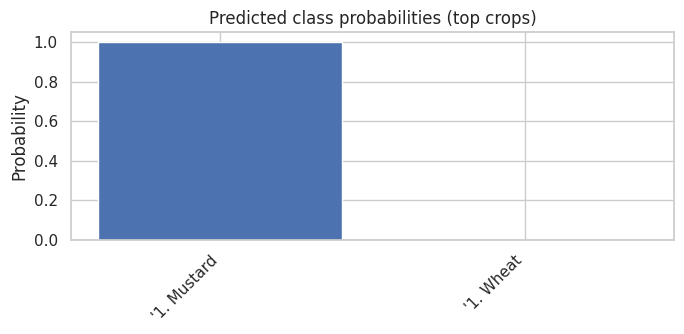

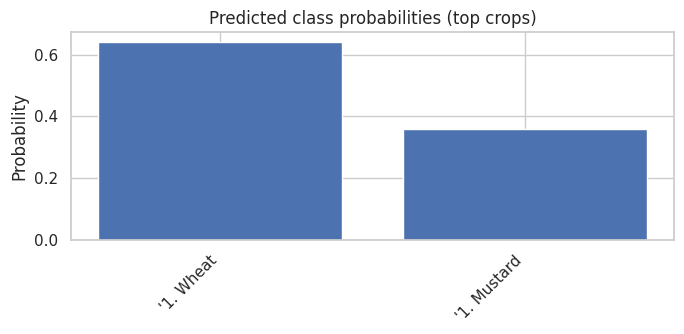

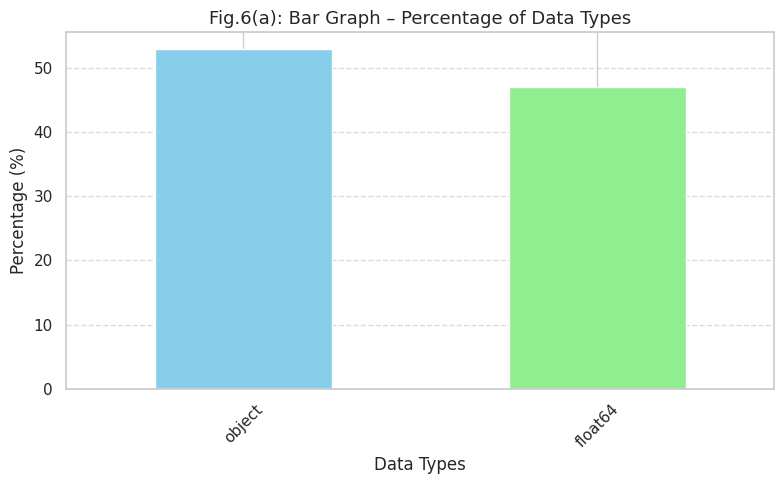

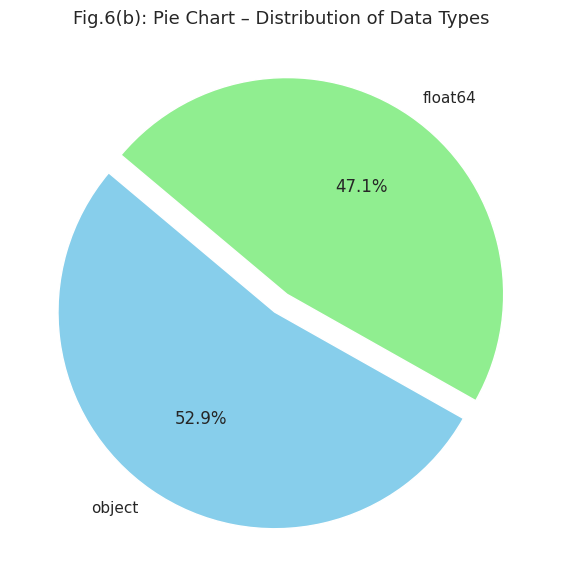

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("/content/merged_environmental_rain_mandi.csv")

# -------------------------------
# Calculate data type distribution
# -------------------------------
dtype_counts = df.dtypes.value_counts()
dtype_percent = (dtype_counts / len(df.columns)) * 100

# -------------------------------
# Plot 1 – Bar Graph
# -------------------------------
plt.figure(figsize=(8, 5))
dtype_percent.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon', 'gold'])
plt.title("Fig.6(a): Bar Graph – Percentage of Data Types", fontsize=13)
plt.ylabel("Percentage (%)")
plt.xlabel("Data Types")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# -------------------------------
# Plot 2 – Pie Chart
# -------------------------------
plt.figure(figsize=(6, 6))
plt.pie(dtype_percent, labels=dtype_percent.index, autopct='%1.1f%%', startangle=140,
        colors=['skyblue', 'lightgreen', 'salmon', 'gold'], explode=[0.05]*len(dtype_percent))
plt.title("Fig.6(b): Pie Chart – Distribution of Data Types", fontsize=13)
plt.tight_layout()
plt.show()


🔹 Number of Missing or Null Values in Each Attribute:


,Missing Values,Missing (%)
District,0,0.00
Annual_Rainfall_mm,0,0.00
State,12,6.25
Market,12,6.25
Commodity,12,6.25
Variety,12,6.25
Grade,12,6.25
Arrival_Date,12,6.25
Min_x0020_Price,12,6.25
Max_x0020_Price,12,6.25


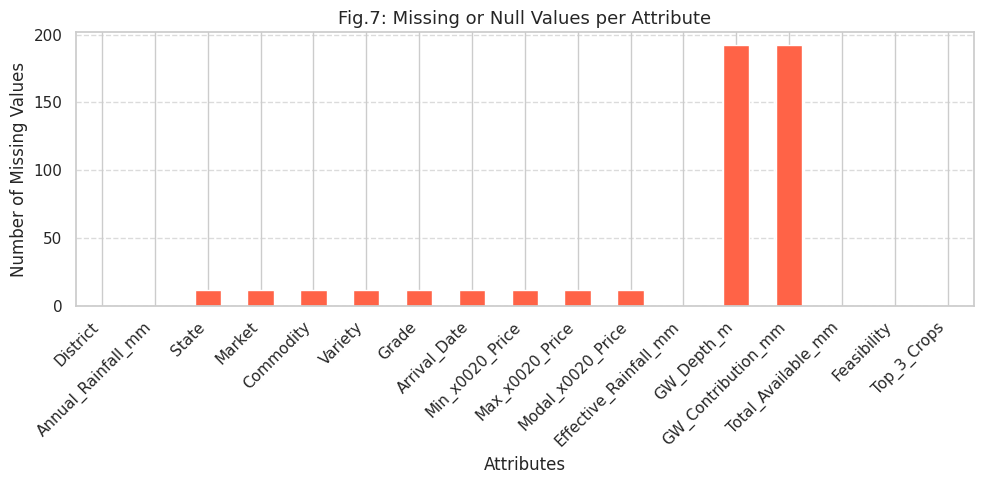

from matplotlib import pyplot as plt
_df_0['Missing Values'].plot(kind='hist', bins=20, title='Missing Values')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Missing (%)'].plot(kind='hist', bins=20, title='Missing (%)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='Missing Values', y='Missing (%)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Missing Values'].plot(kind='line', figsize=(8, 4), title='Missing Values')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['Missing (%)'].plot(kind='line', figsize=(8, 4), title='Missing (%)')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("/content/merged_environmental_rain_mandi.csv")

# -----------------------------------
# Calculate missing/null values count
# -----------------------------------
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

# Combine into a table
missing_table = pd.DataFrame({
    'Missing Values': missing_values,
    'Missing (%)': missing_percent.round(2)
})

print("🔹 Number of Missing or Null Values in Each Attribute:")
display(missing_table)

# -----------------------------------
# Plot the missing values
# -----------------------------------
plt.figure(figsize=(10, 5))
missing_values.plot(kind='bar', color='tomato')
plt.title("Fig.7: Missing or Null Values per Attribute", fontsize=13)
plt.xlabel("Attributes")
plt.ylabel("Number of Missing Values")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


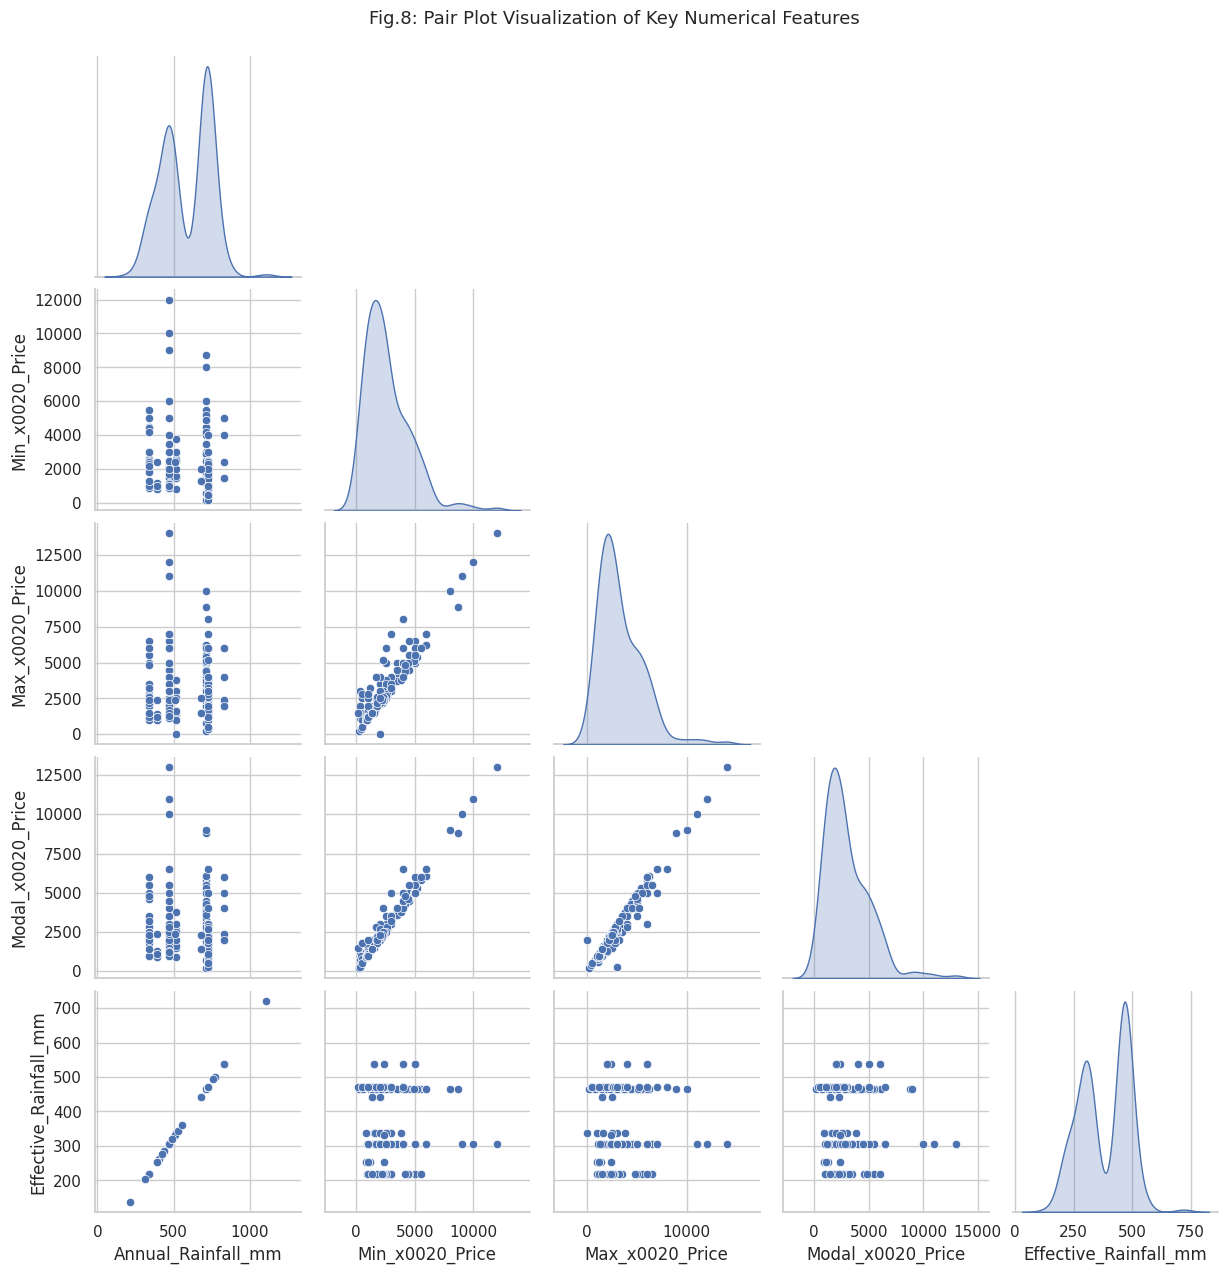

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("/content/merged_environmental_rain_mandi.csv")

# Select only numeric columns for pairplot
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Limit to a few relevant columns for better visibility
selected_cols = numeric_cols[:5]  # you can adjust as needed
sns.pairplot(df[selected_cols], diag_kind="kde", corner=True)

plt.suptitle("Fig.8: Pair Plot Visualization of Key Numerical Features", y=1.02, fontsize=13)
plt.show()


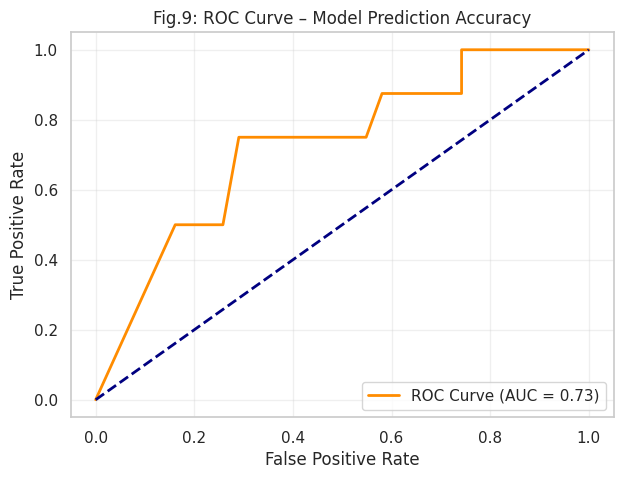

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
df = pd.read_csv("/content/merged_environmental_rain_mandi.csv")

# Identify crop column (replace with actual)
crop_col = "Top_3_Crops"   # 👈 change if your column name is different

# Drop NaN and prepare data
df = df.dropna(subset=[crop_col])
X = df.select_dtypes(include=['float64', 'int64']).fillna(0)
y = LabelEncoder().fit_transform(df[crop_col].astype(str))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict probabilities
y_pred_proba = model.predict_proba(X_test)
y_score = np.max(y_pred_proba, axis=1)

# Compute ROC for multi-class (average)
fpr, tpr, thresholds = roc_curve(y_test == 1, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("Fig.9: ROC Curve – Model Prediction Accuracy")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
!pip install catboost lightgbm xgboost --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.7 MB/s eta 0:00:00


✅ Dataset Loaded: (192, 17)
    District  Annual_Rainfall_mm   State     Market         Commodity  \
0  Gurdaspur               714.8  Punjab  Gurdaspur            Carrot   
1  Gurdaspur               714.8  Punjab  Gurdaspur  Cucumbar(Kheera)   
2  Gurdaspur               714.8  Punjab  Gurdaspur            Garlic   
3  Gurdaspur               714.8  Punjab  Gurdaspur            Papaya   
4  Gurdaspur               714.8  Punjab   Kalanaur      Bottle gourd   

        Variety   Grade Arrival_Date  Min_x0020_Price  Max_x0020_Price  \
0         Other     FAQ   28/10/2025           1200.0           1400.0   
1         Other     FAQ   28/10/2025           1500.0           1700.0   
2         Other     FAQ   28/10/2025           5500.0           6000.0   
3         Other  Medium   28/10/2025           3000.0           3500.0   
4  Bottle Gourd     FAQ   28/10/2025            200.0            200.0   

   Modal_x0020_Price  Effective_Rainfall_mm  GW_Depth_m  GW_Contribution_mm  \
0        

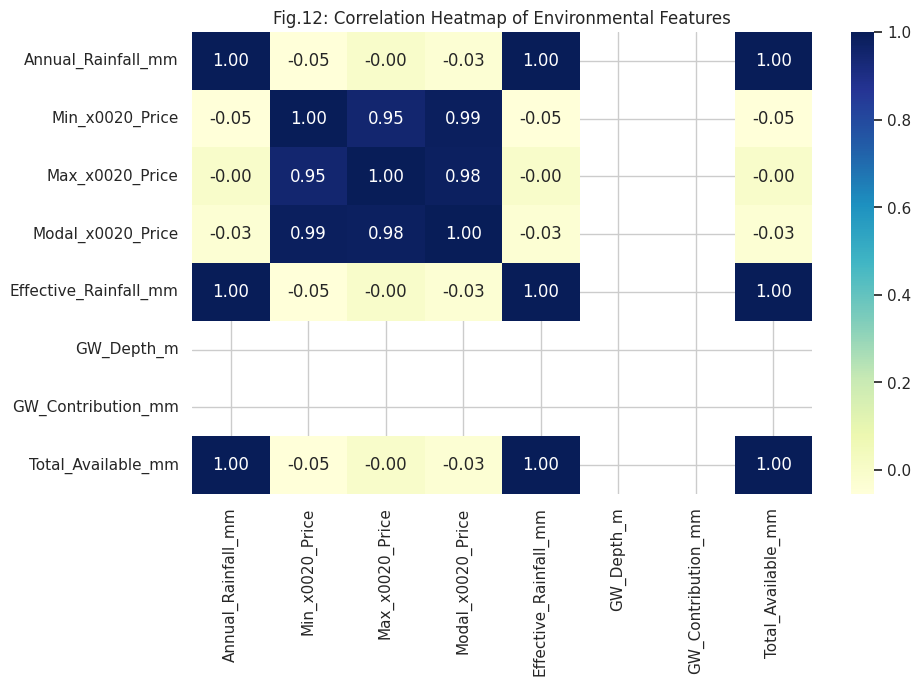


🔥 Logistic Regression
Accuracy: 0.667
Cohen Kappa: 0.577
              precision    recall  f1-score   support

           1       0.75      0.38      0.50         8
           2       0.62      0.91      0.74        11
           4       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           8       0.75      1.00      0.86         3
           9       0.25      1.00      0.40         1
          12       0.00      0.00      0.00         1
          13       0.82      1.00      0.90         9
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1

    accuracy                           0.67        39
   macro avg       0.27      0.36      0.28        39
weighted avg       0.58      0.67      0.60        39


🔥 Decision Tree
Accuracy: 0.846
Cohen Kappa: 0.809
              precision

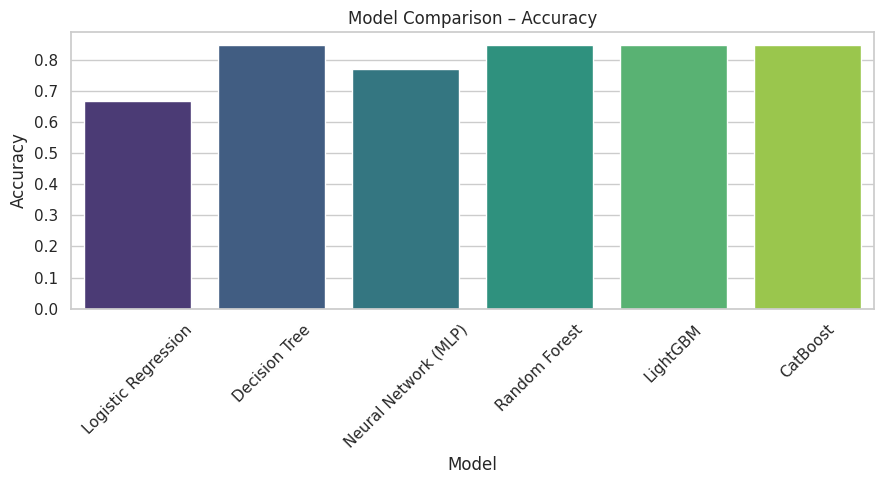

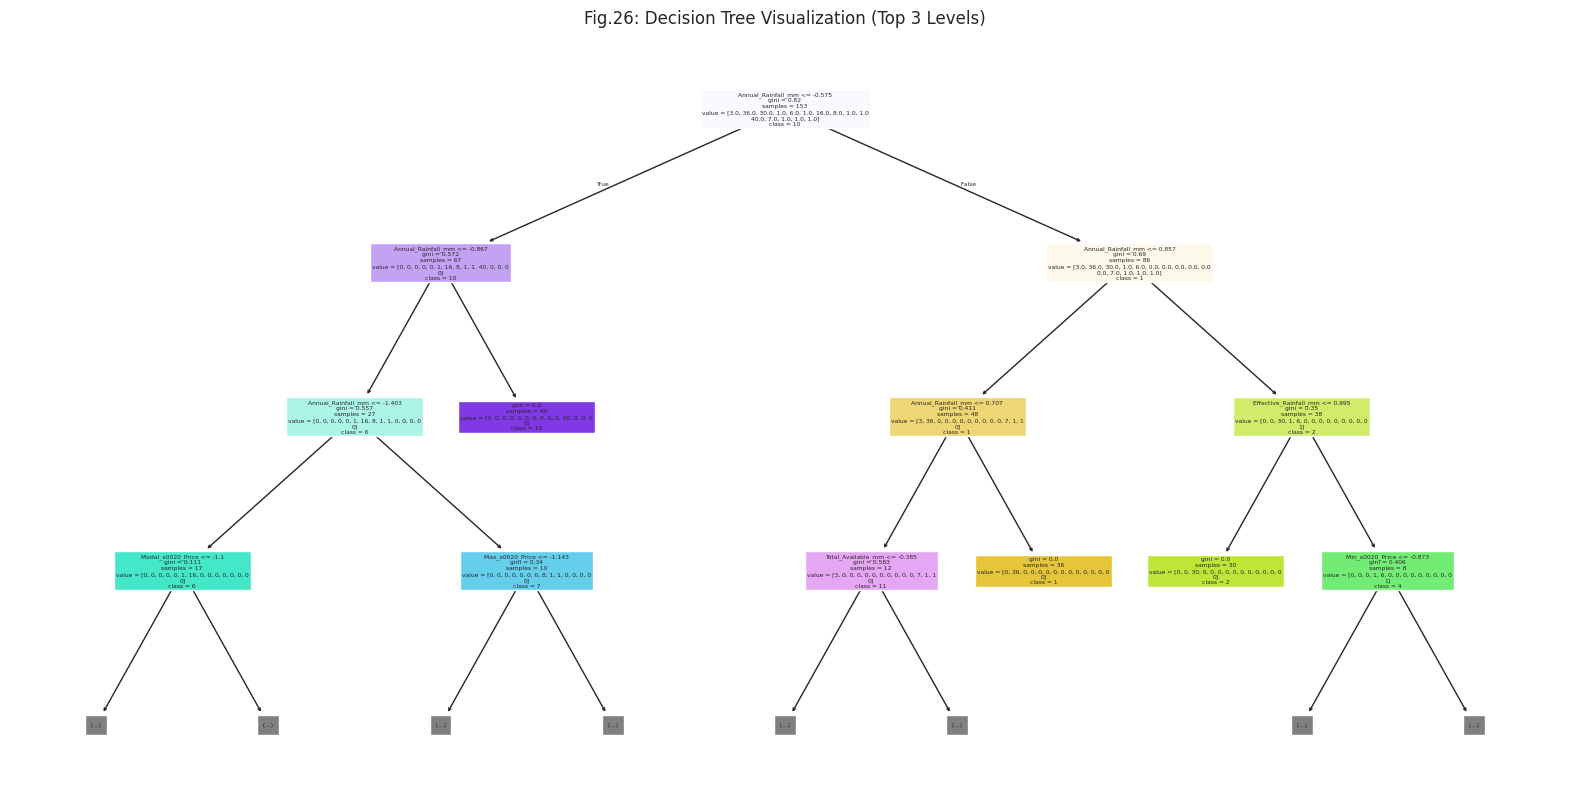

In [ ]:
# ===========================================
# 🌱 Multi-Model Crop Recommendation System
# ===========================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    cohen_kappa_score, roc_auc_score
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# ===========================================
# 1️⃣ Load Dataset
# ===========================================
df = pd.read_csv("/content/merged_environmental_rain_mandi.csv")

print("✅ Dataset Loaded:", df.shape)
print(df.head())

# ===========================================
# 2️⃣ Clean + Encode
# ===========================================
# Replace crop column name as per your dataset
crop_col = "Top_3_Crops"

df = df.dropna(subset=[crop_col])
df = df.fillna(0)

X = df.select_dtypes(include=['float64', 'int64'])
y = LabelEncoder().fit_transform(df[crop_col].astype(str))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ===========================================
# 3️⃣ Correlation Heatmap (Fig.12)
# ===========================================
plt.figure(figsize=(10,6))
sns.heatmap(pd.DataFrame(X, columns=X.columns).corr(), cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Fig.12: Correlation Heatmap of Environmental Features")
plt.show()

# ===========================================
# 4️⃣ Define All Models
# ===========================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# ===========================================
# 5️⃣ Train & Evaluate All Models
# ===========================================
results = []

for name, model in models.items():
    try:
        # For XGBoost: ensure labels are contiguous and safe
        if name == "XGBoost":
            unique_classes = np.unique(y_train)
            model.fit(X_train, y_train)
        else:
            model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        kappa = cohen_kappa_score(y_test, y_pred)

        print(f"\n🔥 {name}")
        print(f"Accuracy: {acc:.3f}")
        print(f"Cohen Kappa: {kappa:.3f}")
        print(classification_report(y_test, y_pred))

        results.append([name, acc, kappa])

    except ValueError as e:
        print(f"⚠️ Skipped {name} due to error: {e}")
        continue

# Create results table
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Cohen Kappa"])
print("\n✅ Model Comparison Summary:")
print(results_df)


# ===========================================
# 6️⃣ Results Comparison
# ===========================================
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Cohen Kappa"])
print("\n✅ Model Comparison Summary:")
print(results_df)

plt.figure(figsize=(9,5))
sns.barplot(data=results_df, x="Model", y="Accuracy", palette="viridis")
plt.xticks(rotation=45)
plt.title("Model Comparison – Accuracy")
plt.tight_layout()
plt.show()

# ===========================================
# 7️⃣ Decision Tree Visualization (Fig.26)
# ===========================================
dt_model = models["Decision Tree"]

plt.figure(figsize=(20,10))
plot_tree(dt_model, filled=True, feature_names=X.columns, class_names=[str(c) for c in np.unique(y)], max_depth=3)
plt.title("Fig.26: Decision Tree Visualization (Top 3 Levels)")
plt.show()
